In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import operator
from operator import itemgetter
import pygraphviz

In [2]:
os.getcwd()

'/Users/Sophie/Documents/GitHub/Analysis_and_Modelling_Social_Interactions'

# Load the data

In [3]:
# import data
df = pd.read_excel('European_electricity_network_vFinal.xlsx', sheet_name='2014')
df.head()

,Origin_Country,Country_Code,AL,AT,BA,BE,BG,CH,CZ,DE,...,NL,NO,PL,PT,RO,RS,SE,SI,SK,TR
0,Albania,AL,NaN,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,165.0,0.0,0.0,0.0,0.0
1,Austria,AT,0.0,NaN,0.0,0.0,0.0,5821,263.0,5484.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3119.0,0.0,0.0
2,Bosnia and Herzegovina,BA,0.0,0.0,NaN,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,614.0,0.0,0.0,0.0,0.0
3,Belgium,BE,0.0,0.0,0.0,NaN,0.0,0,0.0,0.0,...,3040.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bulgaria,BG,0.0,0.0,0.0,0.0,NaN,0,0.0,0.0,...,0.0,0.0,0.0,0.0,43.0,1514.0,0.0,0.0,0.0,5296.0


In [4]:
# drop unnecessary columns
df_elec = df.drop(['Origin_Country'], axis=1)

# Convert the wide table to long table
Country_list = list(df_elec.columns)
df_elec = df_elec.melt(id_vars=['Country_Code'], value_vars=(Country_list[1:]), var_name='Destination', value_name='Electricity_Flow')
df_elec.rename(columns={'Country_Code':'Origin'}, inplace=True)

# Sort the table based on origin country's name
df_elec.sort_values('Origin', inplace=True, ascending=True)

# Delete NAs (when Origin=Destination)
df_elec.dropna(axis=0, inplace=True) 

# Delete zero-value rows
df_elec = df_elec[df_elec.Electricity_Flow != 0]
df_elec.reset_index(drop=True, inplace=True)

df_elec.head()

,Origin,Destination,Electricity_Flow
0,AL,GR,104.0
1,AL,ME,145.0
2,AL,RS,165.0
3,AT,SI,3119.0
4,AT,DE,5484.0


In [5]:
len(df_elec)

119

# Preparation before creating network

## Create country-pair array for graph

In [6]:
# create a list of tuples with nodes and edge
ebunch = list(df_elec.to_records(index=False))

In [7]:
# create a list of Origin-Destination countries and convert to array
graph = np.asarray(df_elec[['Origin', 'Destination']])

## Calculate edge weights

In [8]:
dict = df_elec.set_index(['Origin', 'Destination']).T.to_dict('list')

# create a list of node pairs using Origin-Destination countries
countries = list(dict.keys())
# create a list of weights using electricity flows
weights = list(dict.values())

In [9]:
# countries

In [10]:
# create a list of weights
weights_list = [None] * len(weights)

for i, weight in enumerate(weights):
    weights_list[i] = weights[i][0]

weights_list[:5]
# len(weights_list)

[104.0, 145.0, 165.0, 3119.0, 5484.0]

In [11]:
edge_width_list = [None]*len(weights)
max_weights = max(weights_list)

for i, weight in enumerate(weights_list):
    edge_width_list[i] = weights_list[i]/max_weights*5

edge_width = np.asarray(edge_width_list)

In [12]:
# create a dict for signing edge weights/widths
weights_dict = {countries[i]:weights_list[i] for i in range(len(countries))}

## Calculate total export of each country

In [13]:
# calculate total export for each country
df_total_export = df_elec.groupby(['Origin'], as_index=False).sum()
df_total_export.columns = ['Country', 'Export']
df_total_export.head()

,Country,Export
0,AL,414.0
1,AT,18791.0
2,BA,5998.0
3,BE,4190.0
4,BG,13774.0


In [14]:
# convert export dataframe to np array, to be assigned to node_size
total_export = np.asarray(df_total_export['Export'])

In [15]:
# check top exporting countries
df_total_export_sorted = df_total_export.sort_values(by='Export', ascending=False)
df_total_export_sorted.head()

,Country,Export
12,FR,73575.0
7,DE,68884.0
5,CH,32439.0
30,SE,32348.0
6,CZ,28138.0


In [16]:
# use country names as nodes
node_list = list(df_total_export['Country'])
node_list[:5]

['AL', 'AT', 'BA', 'BE', 'BG']

## Calculate total import of each country

In [17]:
# calculate total import of each country
df_total_import = df_elec.groupby(['Destination'], as_index=False).sum()
df_total_import.columns = ['Country', 'Import']
df_total_import.head()

,Country,Import
0,AL,3407.0
1,AT,28014.0
2,BA,3163.0
3,BE,21698.0
4,BG,4323.0


In [18]:
# convert export dataframe to np array, to be assigned to node_size
total_import = np.asarray(df_total_import['Import'])

In [19]:
# check top importing countries
df_total_import_sorted = df_total_import.sort_values(by='Import', ascending=False)
df_total_import_sorted.head()

,Country,Import
18,IT,46756.0
7,DE,37836.0
24,NL,32853.0
5,CH,28116.0
1,AT,28014.0


## Calculate net export of each country

In [20]:
# calculate net export based on total export and total import
df_net_export = pd.merge(df_total_export, df_total_import, on='Country')
df_net_export['Net_Export'] = df_net_export['Export'] - df_net_export['Import']
df_net_export.head()

,Country,Export,Import,Net_Export
0,AL,414.0,3407.0,-2993.0
1,AT,18791.0,28014.0,-9223.0
2,BA,5998.0,3163.0,2835.0
3,BE,4190.0,21698.0,-17508.0
4,BG,13774.0,4323.0,9451.0


In [21]:
df_net_export_sorted = df_net_export.sort_values(by='Net_Export', ascending=False)
df_net_export_sorted.head()

,Country,Export,Import,Net_Export
12,FR,73575.0,7799.0,65776.0
7,DE,68884.0,37836.0,31048.0
6,CZ,28138.0,11832.0,16306.0
30,SE,32348.0,16148.0,16200.0
25,NO,20879.0,6148.0,14731.0


# Create networks
## Directed network

In [22]:
G = nx.DiGraph()
G.add_nodes_from(node_list)
G.add_weighted_edges_from(ebunch_to_add=ebunch, weight='weight')

In [23]:
pos = nx.spring_layout(G, scale=4)
 
node_size = total_export/20
node_color = [float(G.degree(i)) for i in G]

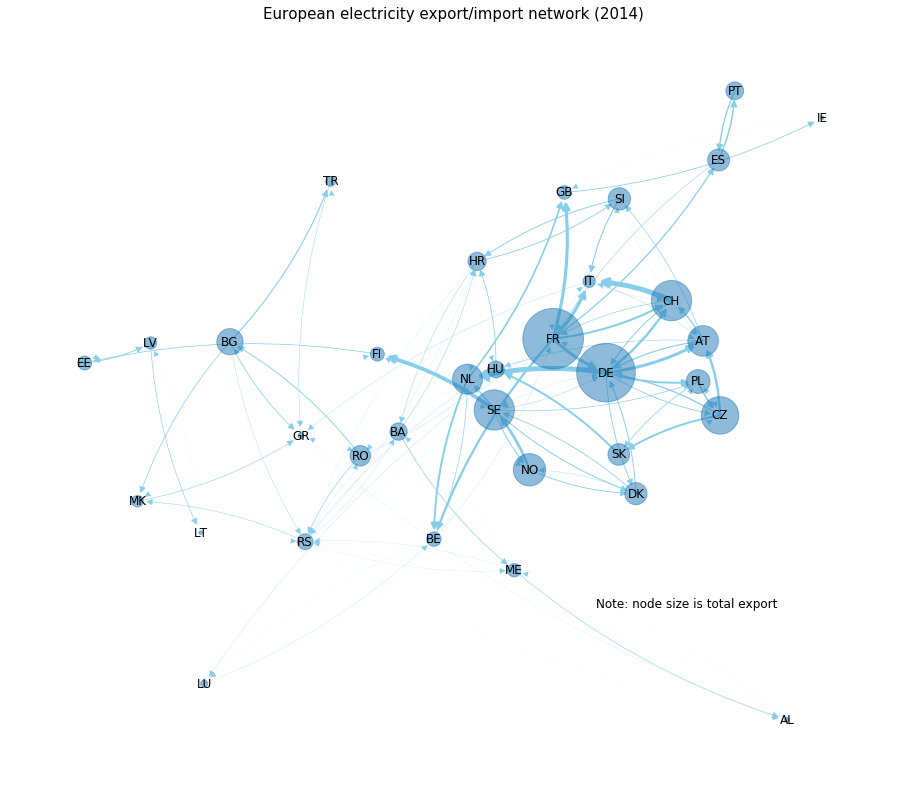

In [26]:
# without centrality

plt.figure(figsize=(16,14))
pos = nx.spring_layout(G, k=8, scale=6, seed=15)
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size, alpha=0.5)
edges = nx.draw_networkx_edges(G, pos, width=edge_width, edge_color='skyblue', 
                       arrowstyle='-|>', arrowsize=14,
                       connectionstyle='arc3,rad=0.1')
nx.draw_networkx_labels(G, pos, font_size=12)

plt.title('European electricity export/import network (2014)', fontsize=15)
plt.text(1.5,-4,'Note: node size is total export', fontsize=12)

plt.axis('off')
plt.show()

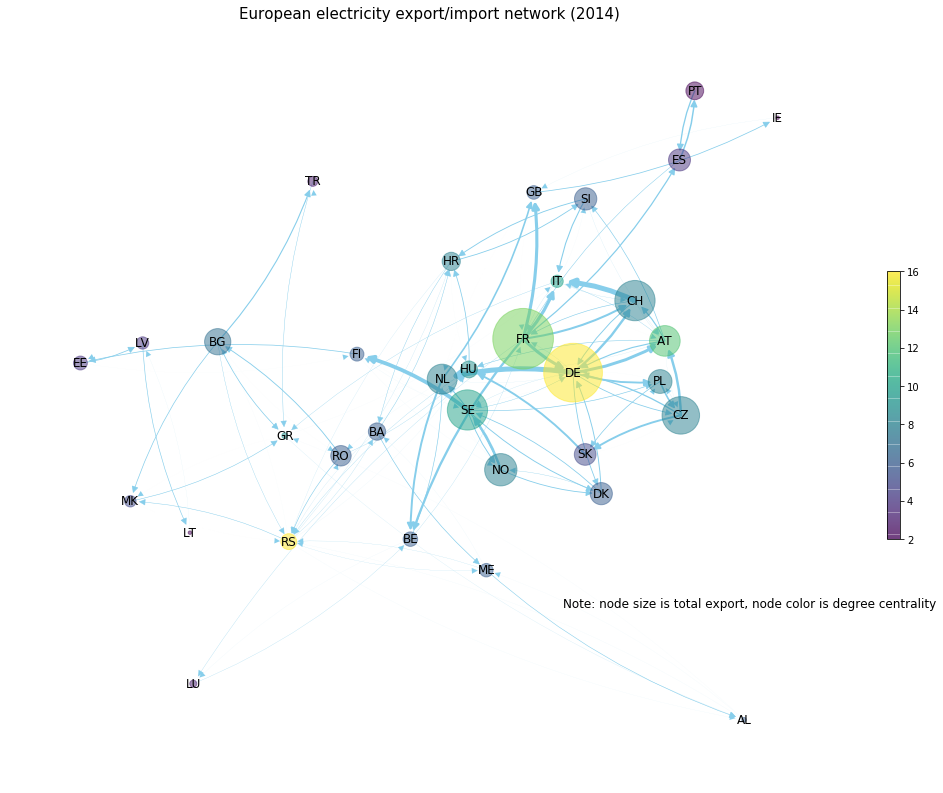

In [27]:
# degree centrality

plt.figure(figsize=(16,14))
pos = nx.spring_layout(G, k=8, scale=6, seed=15)
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, alpha=0.5)
edges = nx.draw_networkx_edges(G, pos, width=edge_width, edge_color='skyblue', 
                       arrowstyle='-|>', arrowsize=14,
                       connectionstyle='arc3,rad=0.1')
nx.draw_networkx_labels(G, pos, font_size=12)

plt.title('European electricity export/import network (2014)', fontsize=15)
plt.text(1.5,-4,'Note: node size is total export, node color is degree centrality', fontsize=12)
cbar = plt.colorbar(mappable=nodes, cax=None, ax=None, fraction=0.015, pad=0.04)

plt.axis('off')
plt.show()

## Betweenness centrality

In [28]:
from graphs import GraphStats

In [29]:
stats = GraphStats()
betc_key, betc_value = stats.calculate_betweenness_centrality(G)
degc_key, degc_value = stats.calculate_degree_centrality(G)

In [30]:
# node_color = [float(G.degree(i)) for i in G]

In [31]:
node_color_betc = betc_value

In [32]:
betc = {'Country': betc_key, 'Betweenness_Centrality': betc_value}
df_betc = pd.DataFrame(betc)
df_betc.head()

,Country,Betweenness_Centrality
0,DE,0.347954
1,FR,0.287025
2,AT,0.250113
3,IT,0.240769
4,SE,0.190421


In [33]:
df_betc_sorted = df_betc.sort_values(by=['Country'])
# df_betc_sorted

In [34]:
betc_list = df_betc_sorted['Betweenness_Centrality'].tolist()
# betc_list

/usr/local/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/usr/local/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


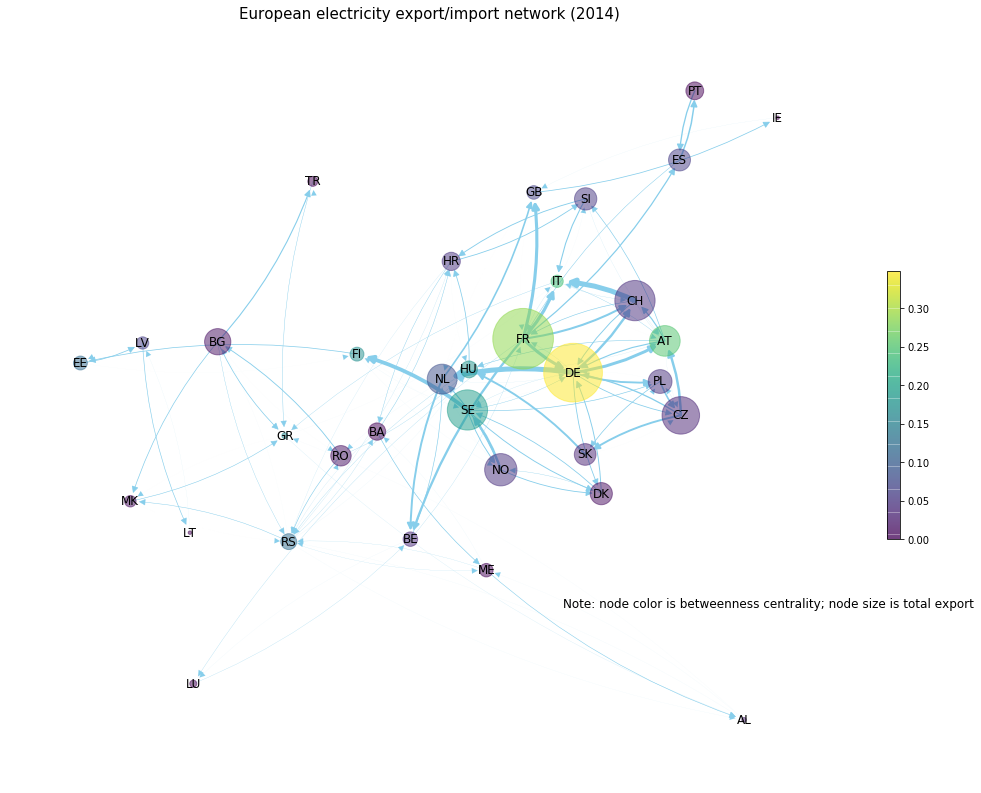

In [35]:
plt.figure(figsize=(16,14))
pos = nx.spring_layout(G, k=8, scale=6, seed=15)
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=betc_list, alpha=0.5)
edges = nx.draw_networkx_edges(G, pos, width=edge_width, edge_color='skyblue', 
                       arrowstyle='-|>', arrowsize=14,
                       connectionstyle='arc3,rad=0.1')
nx.draw_networkx_labels(G, pos, font_size=12)

plt.title('European electricity export/import network (2014)', fontsize=15)
plt.text(1.5,-4,'Note: node color is betweenness centrality; node size is total export', fontsize=12)
cbar = plt.colorbar(mappable=nodes, cax=None, ax=None, fraction=0.015, pad=0.04)

plt.axis('off')
plt.show()